In [1]:
%matplotlib inline

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

from gmm import GMM

# Graphical Models for Image Segmentation

Image segmentation is an important application for graphical models, since they can finely segment scene at a pixel level. In this project, we implement Gaussian Mixture Model to segment the scenes. We also implemented kmeans algorithm to compare the performance between the two.

Gaussian Mixture Model can be defined as following, for $x \in R^d$, for $k$ components with parameters $\mu_k$ and $\sigma_k$, where each component is a multivariate Gaussian density

$$
p_k(x\mid \mu_k, \sigma_k) = \frac{1}{(2\pi)^{d/2}\sigma^{1/2}} e^{-\frac{(x - \mu_k)^2}{2\sigma}}
$$

Expectation Maximization (EM) Algorithm is used to find the parameters that fit the GMM. It is an iterative algorithm and it starts with an initial estimates of the parameters and then iteratively updates the estimate until converged. It consists of an **E-step** and **M-step**.

1. Initialize parameters $\mu_k$ and $\theta_k$

2. E-Step: $p_{ij}^{r+1} = p^{r+1}(i\mid x_j) = p_i^r N(x_j \mid \mu_i^r, \sigma_i^r)$

3. M-Step: 
$$
\hat{p}_i^{r+1} = \frac{1}{n} \sum_{j=1}^n p_{ij}^r
$$

$$
\hat{\mu}_i^{r+1} = \frac{\sum_{j=1}^n p_{ij}^{r+1} x_j}{n\hat{p}_i^{r+1}} 
$$

$$
\hat{\sigma^2}_i^{r+1} = \frac{\sum_{j=1}^n p_{ij}^{r+1}(x_j - \hat{\mu}_i^{r+1})^2}{n\hat{p}_i^{r+1}} 
$$

4. Iterate over 2 and 3 until convergence $\mathcal {L}^{i} - \mathcal {L}^{i-1} < \epsilon$ 

We implemented vectorized GMM-EM algorithm using numpy. We have three stopping conditions for the EM algorithm.
1. difference in likelihood less than $10^{-5}$
2. difference in estimated $\mu$, $\sigma$ is less than $10^{-5}$
3. 1000 iterations

### Experiments

We test both k-means and GMM algorithms on a set of images with various parameters and initializations.
we test for different number of iterations, number of clusters (k), initializations (kmeans, random).


#### sources

- https://en.wikipedia.org/wiki/K-means_clustering
- http://www.inf.u-szeged.hu/ssip/2008/presentations2/Kato_ssip2008.pdf
- http://www.ics.uci.edu/~smyth/courses/cs274/notes/EMnotes.pdf
- http://ijiepr.iust.ac.ir/article-1-19-en.pdf
- http://djafari.free.fr/maxent2006/Papers/008_Zarpak/008_Zarpak.pdf

In [2]:
def kmeans(k, img):
    x = img.copy()
    # random initialization
    means = np.random.random((k,1))
    
    convergence = float('inf')
    while convergence > 10**-8:
        dist = np.linalg.norm(means[:, np.newaxis] - x, axis=2)
        masks = [np.argmin(dist, axis=0) == _x for _x in range(k)]
        old_means = means.copy()
        means = np.array([np.mean(x[mask]) for mask in masks]).reshape((k,1))
        convergence = np.linalg.norm(old_means - means)
    labels = np.zeros(img.shape)
    for i,mask in enumerate(masks):
        labels[mask] = i
    return means, labels


# helper functions

def rgb2gray(img):
    # source: https://stackoverflow.com/a/12201744
    # weights = [0.299, 0.587, 0.114]  # grayscale
    weights = [0.21, 0.72, 0.07]  # luminosity
    return np.dot(img[...,:3], weights)/255.

def gmm_plotter(x, seg, ll):
    fig1 = plt.figure(figsize=(10,10))
    spec2 = gridspec.GridSpec(ncols=2, nrows=2)
    ax1 = fig1.add_subplot(spec2[0, 0])
    ax1.imshow(x, cmap='gray')
    ax2 = fig1.add_subplot(spec2[0, 1])
    ax2.imshow(seg)
    ax3 = fig1.add_subplot(spec2[1, :])
    ax3.plot(ll)
    
    ax3.set_xlabel('iterations')
    ax3.set_ylabel('log likelihood')
    ax3.set_title('Iterations vs Log Likelihood')

def kmeans_plotter(x,seg):
    f, axarr = plt.subplots(1,2, gridspec_kw = {'width_ratios':[1, 1]}, figsize=(16,8))
    a = axarr[0].imshow(x, cmap='gray')
    a = axarr[1].imshow(seg)


def kmeans_algo(filepath, k):
    x = rgb2gray(mpimg.imread(filepath))
    y = x.reshape((x.shape[0]*x.shape[1], 1))
    
    mu, seg = kmeans(k, y)
    
    seg = seg.reshape(x.shape)
    
    kmeans_plotter(x, seg)

def gmm_algo(filepath, k, num_itr=1000, init='kmeans', plot=True):
    x = rgb2gray(mpimg.imread(filepath))
    y = x.reshape((x.shape[0]*x.shape[1], 1))
    
    g = GMM(y, k, init)
    
    seg = g.run(num_itr)
    seg = seg.reshape(x.shape)
    
    ll = g.log_likelihood
    
    if plot: gmm_plotter(x, seg, ll)
    return g

def crossvalidation(filepath):
    ks = range(2,10)
    ll_arr = np.zeros(10)
    for k in ks:
        gmm = gmm_algo(filepath, k, plot=False)
        ll_arr[k] = max(gmm.log_likelihood)
    best_k = np.nanargmax(ll_arr)
    return best_k
    

## Cross Validation

We use log likelihood as a metric to maximize to find the best k value. The code has been commented out since it takes approximately 1 hour to complete when running in parallel.

./img/church.jpg 8

./img/coral.jpg 9

./img/flag1.jpg 5

./img/flag2.jpg 4

./img/horse.jpg 7

./img/lake.jpg 9

./img/people.jpg 9

./img/pepper.jpg 9

./img/plant.jpg 5


In [3]:
# filenames = ['./img/church.jpg',
#             './img/coral.jpg',
#             './img/flag1.jpg',
#             './img/flag2.jpg',
#             './img/horse.jpg',
#             './img/lake.jpg',
#             './img/people.jpg',
#             './img/pepper.jpg',
#             './img/plant.jpg']
# best_scores = []
# for name in filenames:
#     best = crossvalidation(name);
#     best_scores.append(best)


In [4]:
# for x,y in zip(filenames, best_scores):
#     print x, y

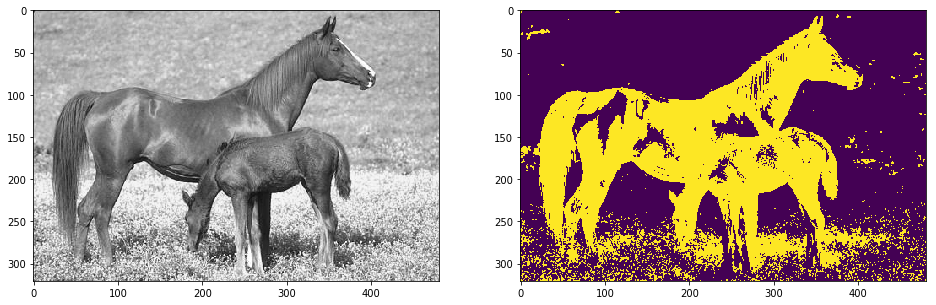

In [5]:
kmeans_algo('./img/horse.jpg', 2)

Fitting complete in 146 Iteration
Mean:  [[0.48270215]
 [0.76969946]]

Variance:  [[0.01273596]
 [0.00897455]]

Weights [[0.35372349]
 [0.64627651]]


<gmm.GMM instance at 0x11725e8c0>

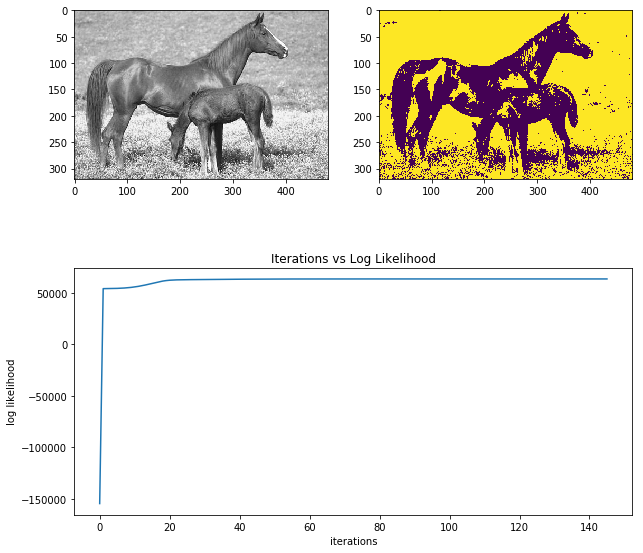

In [6]:
gmm_algo('./img/horse.jpg', 2, init='random')

Fitting complete in 1001 Iteration
Mean:  [[0.24990195]
 [0.75465768]
 [0.46483527]
 [0.54920767]
 [0.51067555]
 [0.41706614]
 [0.93724722]]

Variance:  [[0.00095896]
 [0.0039465 ]
 [0.00787374]
 [0.00362955]
 [0.00903589]
 [0.00648309]
 [0.0006612 ]]

Weights [[0.01463055]
 [0.54666908]
 [0.07194574]
 [0.15769599]
 [0.02398436]
 [0.10339053]
 [0.08168375]]


<gmm.GMM instance at 0x1076e3ef0>

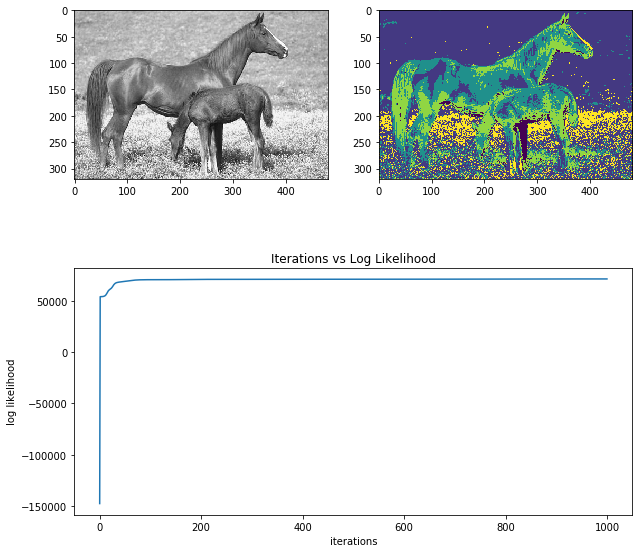

In [21]:
gmm_algo('./img/horse.jpg', 7, init='kmeans')

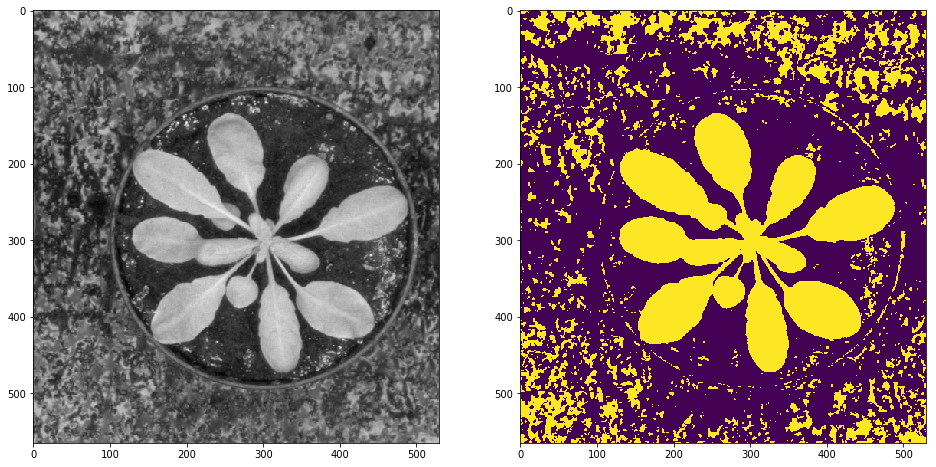

In [8]:
kmeans_algo('./img/plant.jpg', 2)

Fitting complete in 322 Iteration
Mean:  [[0.27630018]
 [0.57218828]]

Variance:  [[0.00886326]
 [0.00312738]]

Weights [[0.79287762]
 [0.20712238]]


<gmm.GMM instance at 0x1092d7998>

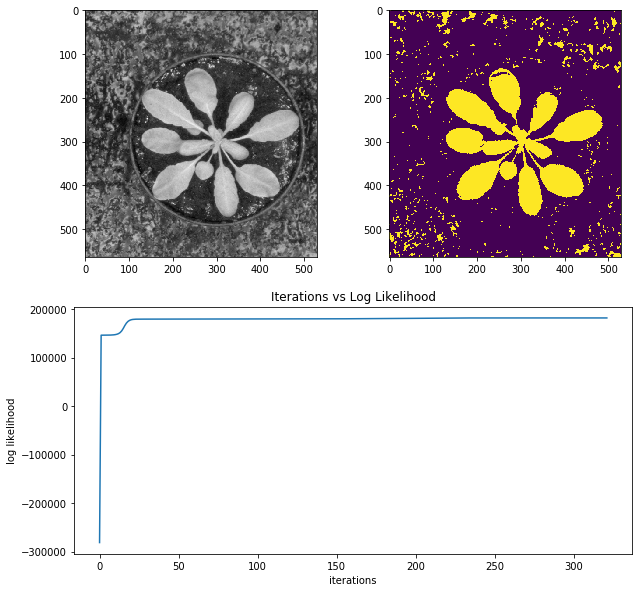

In [9]:
gmm_algo('./img/plant.jpg', 2, init='kmeans')

Fitting complete in 6 Iteration
Mean:  [[0.32062553]
 [0.35770539]]

Variance:  [[0.01949521]
 [0.02434114]]

Weights [[0.54261696]
 [0.45738304]]


<gmm.GMM instance at 0x117268710>

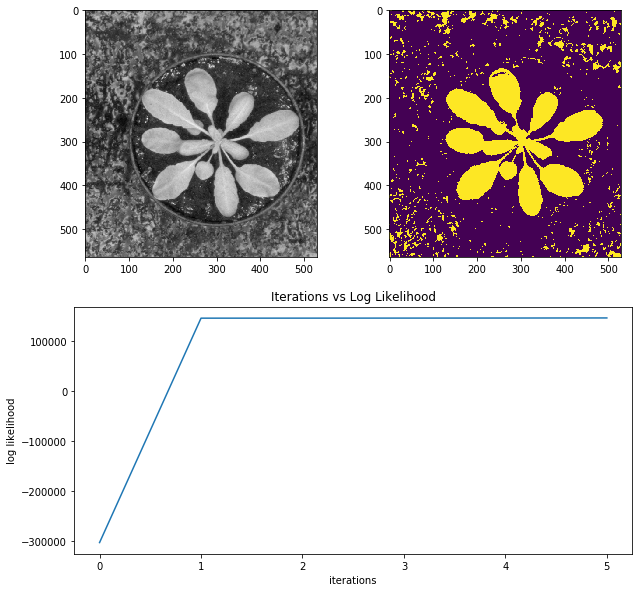

In [10]:
gmm_algo('./img/plant.jpg', 2, num_itr=5, init='random')

## Some more examples

images are taken from  __The Berkeley Segmentation Dataset and Benchmark__

Fitting complete in 18 Iteration
Mean:  [[0.20917647]
 [0.67147522]
 [1.        ]]

Variance:  [[7.70366457e-34]
 [1.39909899e-01]
 [6.19571848e-26]]

Weights [[0.62226665]
 [0.03593044]
 [0.34180291]]


<gmm.GMM instance at 0x108f80290>

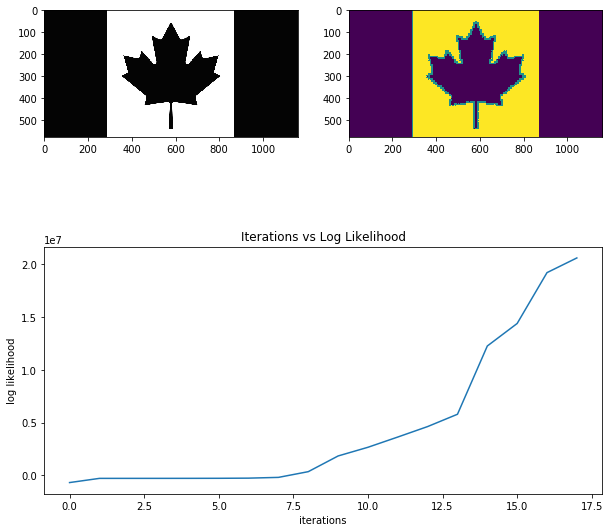

In [25]:
gmm_algo('./img/flag1.jpg', 3, init='kmeans')
# source: https://www.reddit.com/r/vexillology/

Fitting complete in 27 Iteration
Mean:  [[1.        ]
 [0.99032771]
 [0.76287568]
 [0.99699878]
 [0.2840915 ]
 [0.25221742]]

Variance:  [[1.15475637e-23]
 [3.74456412e-05]
 [2.91960781e-02]
 [2.37018348e-06]
 [5.33903334e-03]
 [2.21447079e-05]]

Weights [[0.34729119]
 [0.0092738 ]
 [0.00544867]
 [0.03622429]
 [0.01209992]
 [0.58966213]]


<gmm.GMM instance at 0x1060c93f8>

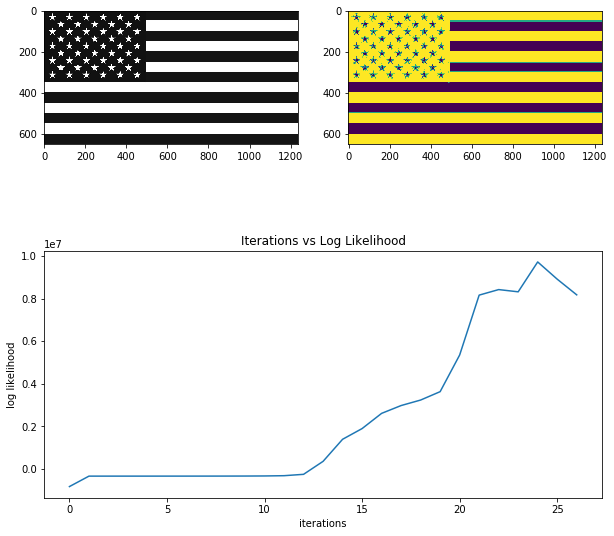

In [12]:
gmm_algo('./img/flag2.jpg', 4, init='kmeans')
# source: https://www.reddit.com/r/vexillology/

#### Segmenting flags is really good since they have very distinct boundary

Fitting complete in 1001 Iteration
Mean:  [[0.39384741]
 [0.5609647 ]
 [0.60480451]
 [0.27861718]
 [0.41540199]
 [0.35689949]
 [0.1905442 ]]

Variance:  [[0.00496109]
 [0.00341019]
 [0.00085633]
 [0.00433416]
 [0.00733153]
 [0.00525815]
 [0.00163227]]

Weights [[0.06676926]
 [0.10810798]
 [0.07700372]
 [0.26491942]
 [0.0661334 ]
 [0.1401745 ]
 [0.27689171]]


<gmm.GMM instance at 0x108fc74d0>

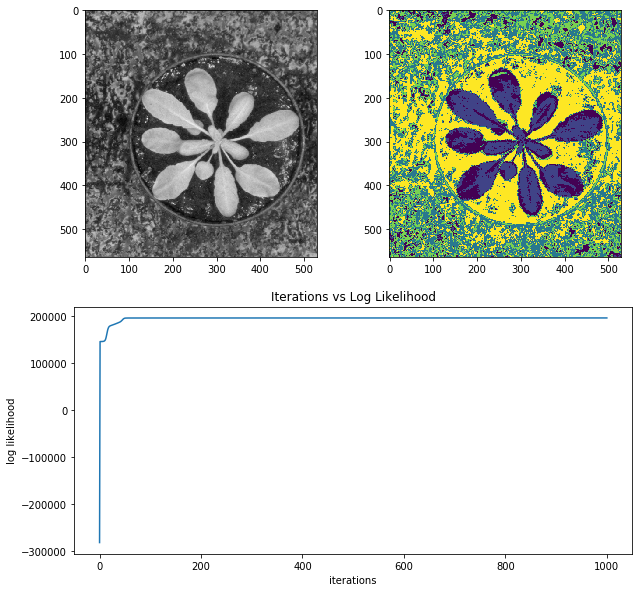

In [23]:
gmm_algo('./img/plant.jpg', 5, init='kmeans')

Fitting complete in 1001 Iteration
Mean:  [[0.38381016]
 [0.48617773]
 [0.34209018]
 [0.99112158]
 [0.98030377]
 [0.86612235]
 [0.96345423]
 [0.93823899]
 [0.11671237]]

Variance:  [[8.13306644e-04]
 [2.15455227e-02]
 [1.38974570e-04]
 [2.13302506e-06]
 [3.60421357e-05]
 [2.45167511e-03]
 [1.14540294e-04]
 [3.67874648e-04]
 [6.16372186e-04]]

Weights [[0.32942481]
 [0.16393623]
 [0.14141932]
 [0.07890743]
 [0.15174577]
 [0.01720243]
 [0.06127512]
 [0.05126143]
 [0.00482746]]


<gmm.GMM instance at 0x111d1fb48>

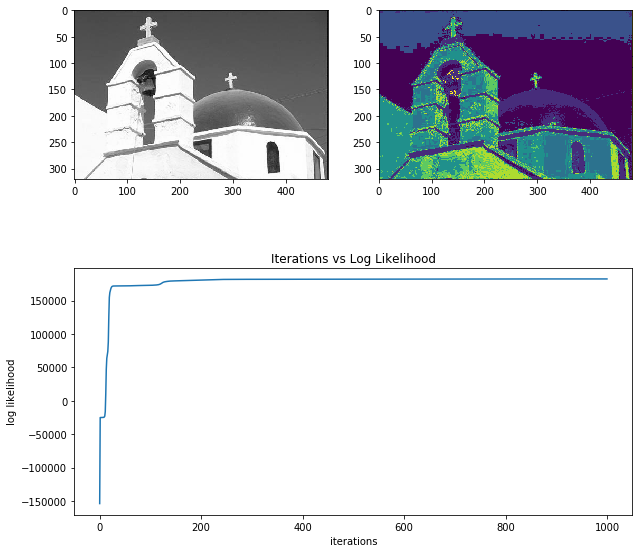

In [14]:
gmm_algo('./img/church.jpg', 8, init='kmeans')

Fitting complete in 1001 Iteration
Mean:  [[0.27009044]
 [0.52068117]
 [0.63216746]
 [0.4500594 ]
 [0.96100078]
 [0.86464176]
 [0.86490718]
 [0.77075508]
 [0.53849242]]

Variance:  [[0.00562623]
 [0.012825  ]
 [0.0095025 ]
 [0.01158473]
 [0.00036612]
 [0.00223314]
 [0.0001674 ]
 [0.00449494]
 [0.01167304]]

Weights [[0.52276701]
 [0.03095025]
 [0.02281566]
 [0.03583887]
 [0.10704554]
 [0.11729289]
 [0.04843924]
 [0.08534924]
 [0.02950129]]


<gmm.GMM instance at 0x11387bd88>

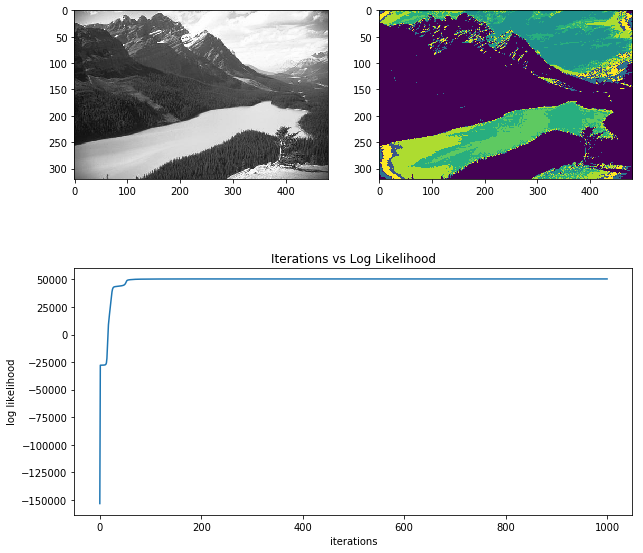

In [15]:
gmm_algo('./img/lake.jpg', 9, init='kmeans')

#### This one does a really good job of seperating the sky from the lake and mountains

Fitting complete in 1001 Iteration
Mean:  [[0.46776648]
 [0.12927556]
 [0.28276629]
 [0.97440045]
 [0.04108623]
 [0.05242052]
 [0.64040743]
 [0.61275041]
 [0.51096478]]

Variance:  [[1.10376752e-02]
 [2.24055634e-03]
 [7.97829069e-03]
 [2.24163980e-04]
 [1.48079261e-05]
 [3.94174293e-04]
 [1.82042234e-02]
 [1.94165357e-02]
 [8.98229053e-03]]

Weights [[0.18958457]
 [0.10394059]
 [0.20227435]
 [0.02106521]
 [0.02989826]
 [0.12005189]
 [0.06047418]
 [0.19519127]
 [0.07751968]]


<gmm.GMM instance at 0x111d2e290>

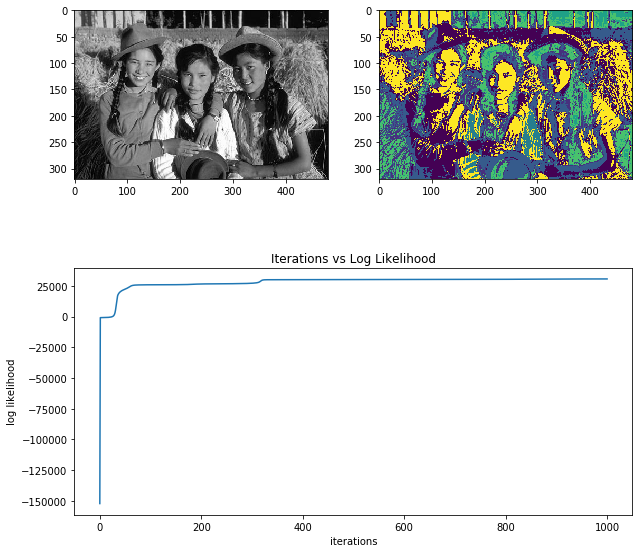

In [16]:
gmm_algo('./img/people.jpg', 9, init='kmeans')

Fitting complete in 1001 Iteration
Mean:  [[0.1121697 ]
 [0.81278113]
 [0.03967601]
 [0.65067486]
 [0.52509812]
 [0.27053418]
 [0.55128197]
 [0.51168221]
 [0.50343624]]

Variance:  [[2.02238636e-03]
 [8.33916359e-03]
 [4.10807092e-05]
 [1.35429597e-03]
 [1.89640265e-02]
 [5.32927901e-03]
 [1.79771561e-02]
 [5.15764279e-03]
 [1.83492868e-02]]

Weights [[0.1185289 ]
 [0.11822302]
 [0.04280643]
 [0.06294332]
 [0.08092562]
 [0.31196345]
 [0.08109154]
 [0.10445325]
 [0.07906447]]


<gmm.GMM instance at 0x112dda050>

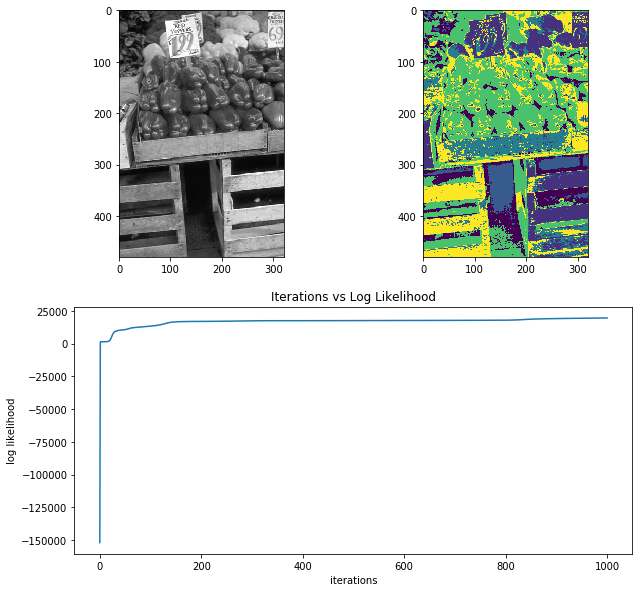

In [17]:
gmm_algo('./img/pepper.jpg', 9, init='kmeans')

Fitting complete in 1001 Iteration
Mean:  [[0.56826264]
 [0.94047688]
 [0.9871917 ]
 [0.23435109]
 [0.79042986]
 [0.38255244]
 [0.14028135]
 [0.15779835]]

Variance:  [[1.65630837e-02]
 [8.26284606e-04]
 [6.40830254e-05]
 [3.21825361e-03]
 [6.60884568e-03]
 [6.37790599e-03]
 [1.04698582e-04]
 [5.13195015e-04]]

Weights [[0.1240772 ]
 [0.0160381 ]
 [0.0105358 ]
 [0.15563276]
 [0.06970601]
 [0.08036295]
 [0.42347874]
 [0.12016844]]


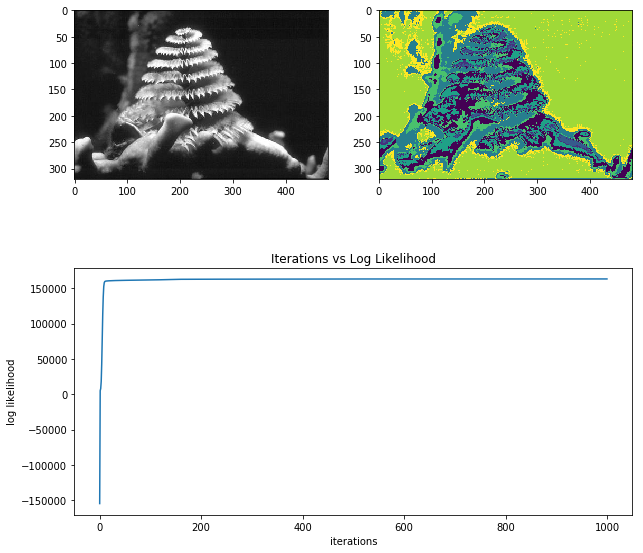

In [18]:
coral = gmm_algo('./img/coral.jpg', 9, init='kmeans')

## Possible Extension

- One possible extension to this work would be to use a conditional random field to perform the segmentation, which can perform a more semantic segmentation of the data.
- another problem here is picking the number of segments (k). One method I tried was using a histogram but did not improve the results much. Another method was cross validation to maximize log likelihood.